### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут
1) $$-\frac{dL}{da} = 2(y_i - a(x_i))$$
2) $$-\frac{dL}{da} = y_i \exp(-a(x_i)y_i)$$
3) $$-\frac{dL}{da} = \frac{y_i \exp(-a(x_i)y_i)}{1+ \exp(-a(x_i)y_i)}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций 

б) размер шага

в) процент случайных фичей при построении одного дерева

д) процент случайных объектов при построении одного дерева

е) параметры базового алгоритма (передавайте через **kwargs)

In [162]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [179]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='MSE', learning_rate=0.1, n_estimators=10,
                 colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.__grad_func = self.__grad_exp
        
#         print(loss)
        
        if self.loss == 'MSE':
            self.__grad_func = self.__grad_mse
#             print('dfgdfg')
        if self.loss == 'exp':
            self.__grad_func = self.__grad_exp
        if self.loss == 'logloss':
            self.__grad_func = self.__grad_logloss 
#         print(self.__grad_func)
    
    def __grad_mse(self, y, a):
#         print(2 * (y - a))
        return 2 * (y - a)
    
    def __grad_exp(self, y, a):
        return y * np.exp(-a * y)
    
    def __grad_logloss(self, y, a):
        return y * np.exp(-a * y) / (1 + np.exp(-a * y))
    
    def get_indexes(self, X):
        X_indexes = np.random.choice(X.shape[0], 
                                     int(self.X.shape[0] * self.subsample))
        y_indexes = np.random.choice(X.shape[1], 
                                     int(self.X.shape[1] * self.colsample))
        return X_indexes, y_indexes
    
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.X = X
        self.y = y
        self.__base_model = base_model
        self.__init_model = init_model
        self.classes = np.unique(y)
        self.n_class = len(self.classes)
        self.models = []
        self.features = []
        
        if init_model is None:
            self.init_model = None
            self.target_predict=np.float64(np.ones(self.y.shape[0]) / self.y.shape[0])
        else:
            self.init_model = init_model(*self.args, **self.kwargs)
            self.init_model.fit(X, y)
            self.target_predict = np.float64(self.init_model.predict(X))
        
        for i in range(self.n_estimators):
            X_indexes, y_indexes = self.get_indexes(X)
            X_train = X[X_indexes, :][:, y_indexes]
            y_train = y[X_indexes]
            X_test = X[:, y_indexes]
            previous_pred = self.target_predict[X_indexes]
            
            self.features.append(y_indexes)
            model = self.__base_model(*self.args, **self.kwargs)
            self.models.append(model)
            target = self.__grad_func(y_train, previous_pred)
            model.fit(X_train, target)
            self.target_predict += self.learning_rate * model.predict(X_test)
        
    def predict(self, X):

        if self.init_model is None:
            y_pred = np.float64(np.ones(X.shape[0]) / X.shape[0])
        else:
            y_pred = np.float64(self.init_model.predict(X))
        for model, feat in zip(self.models, self.features):
            y_pred += self.learning_rate * model.predict(X[:, feat])
        return np.around(y_pred)


In [180]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [181]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [183]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [21]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [22]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [23]:
kf = KFold(n_splits=5)
n_estimat = [x for x in range(1, 200, 20)]
acc_score = []
for n in n_estimat:
    scores = []
    print(n)
    for train_ind, test_ind in kf.split(X):
        X_train = X[train_ind]
        y_train = y[train_ind]
        X_test = X[test_ind]
        y_test = y[test_ind]
        my_clf = MyGradientBoostingClassifier(n_estimators=n)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    acc_score.append(np.mean(scores))

1
21
41
61
81
101
121
141
161
181


In [24]:
print(acc_score)

[0.5780523255813954, 0.8160368217054262, 0.8000484496124031, 0.8035368217054263, 0.8040697674418604, 0.7947189922480621, 0.8040213178294573, 0.8022286821705427, 0.7974806201550387, 0.7984496124031008]


In [6]:
acc_score = [0.5780523255813954, 0.8160368217054262, 0.8000484496124031, 0.8035368217054263, 0.8040697674418604, 0.7947189922480621, 0.8040213178294573, 0.8022286821705427, 0.7974806201550387, 0.7984496124031008]

In [25]:
np.max(acc_score)

0.8160368217054262

Text(0, 0.5, 'accuracy')

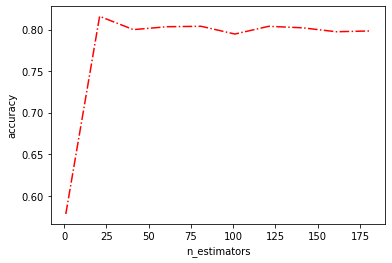

In [9]:
fig = plt.figure()
plt.plot(n_estimat, acc_score, 'r-.')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

In [19]:
param_grid = {'loss' : ['MSE', 'epx', 'logloss'], 
         'n_estimators' : [5, 10, 15, 20, 25], 
         'learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.5], 
          'colsample' : [0.2, 0.5, 0.7, 1],
          'subsample' : [0.2, 0.5, 0.7, 1], 
         }

In [81]:
params = {}

In [80]:
kf = KFold(n_splits=5)
loss = ['MSE', 'epx', 'logloss']
acc_score = []
for l in loss:
    scores = []
    for train_ind, test_ind in kf.split(X):
        X_train = X[train_ind]
        y_train = y[train_ind]
        X_test = X[test_ind]
        y_test = y[test_ind]
        my_clf = MyGradientBoostingClassifier(loss=l)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    acc_score.append(np.mean(scores))

MSE
epx
logloss


In [82]:
print(acc_score)
print(np.max(acc_score))
print(loss[np.argmax(acc_score)])

[0.7996608527131783, 0.7762596899224807, 0.5780523255813954]
0.7996608527131783
MSE


In [83]:
params['loss'] = loss[np.argmax(acc_score)]

loss = MSE

In [90]:
params

{'loss': 'MSE', 'n_estimators': 25}

In [87]:
kf = KFold(n_splits=5)
n_estimators = [5, 10, 15, 20, 25]
acc_score = []
for n in n_estimators:
    scores = []
    for train_ind, test_ind in kf.split(X):
        X_train = X[train_ind]
        y_train = y[train_ind]
        X_test = X[test_ind]
        y_test = y[test_ind]
        my_clf = MyGradientBoostingClassifier(n_estimators = n, **params)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    acc_score.append(np.mean(scores))

In [89]:
print(acc_score)
print(np.max(acc_score))
print(n_estimators[np.argmax(acc_score)])
params['n_estimators'] = n_estimators[np.argmax(acc_score)]

[0.764437984496124, 0.7838662790697675, 0.8103682170542635, 0.8000484496124031, 0.8105620155038759]
0.8105620155038759
25


n_estimators = 25

In [92]:
kf = KFold(n_splits=5)
learning_rate = [0.1, 0.2, 0.3, 0.4, 0.5] 
acc_score = []
for l in learning_rate:
    scores = []
    for train_ind, test_ind in kf.split(X):
        X_train = X[train_ind]
        y_train = y[train_ind]
        X_test = X[test_ind]
        y_test = y[test_ind]
        my_clf = MyGradientBoostingClassifier(learning_rate = l, **params)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    acc_score.append(np.mean(scores))

In [93]:
print(acc_score)
print(np.max(acc_score))
print(learning_rate[np.argmax(acc_score)])
params['learning_rate'] = learning_rate[np.argmax(acc_score)]

[0.8091569767441861, 0.7774224806201551, 0.7246124031007751, 0.6005813953488371, 0.5354651162790697]
0.8091569767441861
0.1


In [94]:
kf = KFold(n_splits=5)
colsample = [0.2, 0.5, 0.7, 1]
acc_score = []
for c in colsample:
    scores = []
    for train_ind, test_ind in kf.split(X):
        X_train = X[train_ind]
        y_train = y[train_ind]
        X_test = X[test_ind]
        y_test = y[test_ind]
        my_clf = MyGradientBoostingClassifier(colsample = c, **params)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    acc_score.append(np.mean(scores))

In [95]:
print(acc_score)
print(np.max(acc_score))
print(colsample[np.argmax(acc_score)])
params['colsample'] = colsample[np.argmax(acc_score)]

[0.6354651162790697, 0.7456879844961241, 0.7891472868217054, 0.787015503875969]
0.7891472868217054
0.7


In [96]:
kf = KFold(n_splits=5)
subsample = [0.2, 0.5, 0.7, 1] 
acc_score = []
for s in subsample:
    scores = []
    for train_ind, test_ind in kf.split(X):
        X_train = X[train_ind]
        y_train = y[train_ind]
        X_test = X[test_ind]
        y_test = y[test_ind]
        my_clf = MyGradientBoostingClassifier(subsample = s, **params)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    acc_score.append(np.mean(scores))

In [97]:
print(acc_score)
print(np.max(acc_score))
print(subsample[np.argmax(acc_score)])
params['subsample'] = subsample[np.argmax(acc_score)]

[0.7250968992248061, 0.7847383720930232, 0.7751453488372093, 0.789001937984496]
0.789001937984496
1


In [98]:
params

{'loss': 'MSE',
 'n_estimators': 25,
 'learning_rate': 0.1,
 'colsample': 0.7,
 'subsample': 1}

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 22)

In [102]:
my_clf = MyGradientBoostingClassifier(**params)
my_clf.fit(X_train, y_train)
accuracy_score(y_test, my_clf.predict(X_test))

0.8771802325581395

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [104]:
my_clf = MyGradientBoostingClassifier(**params)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
accuracy_score(y_test, my_clf.predict(X_test))

0.8839631782945736

In [138]:
def get_samples(X, y):
    n_samples = len(X)
    indx = np.random.randint(0, len(X), len(X))
    return X[indx], y[indx]

In [139]:
clf = []

In [141]:
for N in range(15):
    X_bootstrap, y_bootstrap = get_samples(X_train, y_train)
    my_clf = MyGradientBoostingClassifier(**params)
    my_clf.fit(X_bootstrap, y_bootstrap)
    clf.append(my_clf)

In [155]:
pred = [my_clf.predict(X_test) for my_clf in clf]
y_pred = (np.mean(pred, axis=0) > 0.5).astype('int')

In [156]:
accuracy_score(y_test, y_pred)

0.8946220930232558

Качество улучшилось. 
В первом случае предсказание строится путем усреднения предсказаний каждого из построенных деревьев, в результате получаем более несмещенную модель. 
В случае BagBoo за счет бустинга мы уменьшаем дисперсию построенных моделей

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [168]:
my_clf = MyGradientBoostingClassifier()
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8607073643410853

In [169]:
my_clf = MyGradientBoostingClassifier()
my_clf.fit(X_train, y_train, init_model=SVC)
y_pred = my_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8616763565891473

In [170]:
my_clf = MyGradientBoostingClassifier()
my_clf.fit(X_train, y_train, init_model=SGDClassifier)
y_pred = my_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8347868217054264

In [171]:
my_clf = MyGradientBoostingClassifier()
my_clf.fit(X_train, y_train, init_model=RandomForestRegressor)
y_pred = my_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8832364341085271

In [172]:
my_clf = MyGradientBoostingClassifier()
my_clf.fit(X_train, y_train, init_model=RandomForestClassifier)
y_pred = my_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8829941860465116

В случае инициализации RandomForest качество стало лучше, тк после инициализации RF получаем более точное решение

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

